In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import warnings
warnings.filterwarnings("ignore")

In [5]:
from loadRIPA import *
df = loadRIPA()
df['year-month'] = pd.to_datetime(df.date_stop, format='%Y-%m-%d').dt.strftime("%Y-%m")

In [6]:
# create a temporary dataframe to check the frequency of top 15 penal code in the stop reason
reason_df = df.groupby(['reason_for_stop_code_text'], as_index=False).size()
reason_df = reason_df.sort_values(['size'], ascending=False).reset_index(drop=True)
reason_df[:20]

,reason_for_stop_code_text,size
0,65002 ZZ - LOCAL ORDINANCE VIOL (I) 65002,53832
1,602 PC - TRESPASSING (M) 32022,38899
2,22450(A) VC - FAIL STOP VEH:XWALK/ETC (I) 54167,35548
3,22350 VC - UNSAFE SPEED:PREVAIL COND (I) 54106,33232
4,647(E) PC - DIS CON:LODGE W/O CONSENT (M) 32111,32985
5,4000(A)(1) VC - NO REG:VEH/TRAILER/ETC (I) 54657,32719
6,65000 ZZ - LOCAL ORDINANCE VIOL (M) 65000,27349
7,5200(A) VC - DISPLAY LIC PLATES WRONG (I) 54644,23039
8,NA - XX ZZ - COMMUNITY CARETAKING (X) 99990,22749
9,22349(A) VC - EXCEED SPEED ON HIGHWAY (I) 54303,17617


5&18 can go together; 2&10

4000(A)(1) VC - NO REG:VEH/TRAILER/ETC (I) 54657
5204(A) VC - EXPIRED TABS/FAIL DISPLAY (I) 54168

22450(A) VC - FAIL STOP VEH:XWALK/ETC (I) 54167
21461(A) VC - DRIVER FAIL OBEY SIGN/ETC (I) 54146

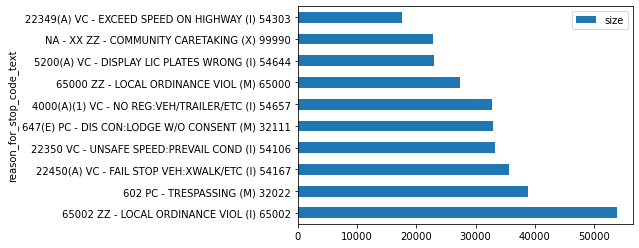

In [7]:
# sample plot of the 10 most common reason 
temp = reason_df.head(10)
temp.plot.barh(x="reason_for_stop_code_text", y=["size"])
plt.show()

#### Outcome Test

We are going to explore whether or not there exists a racial disparity in some of the common stop violations, such as speeding, public intoxication, community caretaking, along with homeless-related stops by using the outcome test to see which violation expresses an unusual result.

In [8]:
def out_vs_pop(black, num1, num2):
    ratio2 = num2 / (3276208 * 0.438)
    if black == 1:
        ratio1 = num1 / (3276208 * 0.056)
    else:
        ratio1 = num1 / (3276208 * 0.348)
    return ratio1/ratio2

In [9]:
cols1 = ['total', ('percent', 'Asian'), ('percent', 'Black/African American'), ('percent', 'Hispanic/Latino/a'), ('percent', 'White')] 
cols2 = ['total', ('percent', 'No Action'), ('percent', 'Warning'), ('percent', 'Citation'), ('percent', 'Arrested')]

In [10]:
# First, we categorized each stop outcome into 3 groups: arrested, citation, and warning
trans = {'Citation for infraction':'Citation', 'In-field cite and release':'Citation', 
         'Custodial Arrest without warrant':'Arrested', 'Contacted U.S. Department of Homeland Security':'Arrested',
         'Psychiatric hold':'Psychiatric Hold', 'Custodial Arrest pursuant to outstanding warrant':'Arrested', 
         'Warning (verbal or written)':'Warning', 'Field interview card completed':'No Action', 'No Action':'No Action',
         'Noncriminal transport or caretaking transport':'Transported',  
         'Contacted parent/legal guardian or other person responsible for the minor':'Parents Contacted',
         'Referral to school administrator':'Referred to school', 
         'Referral to school counselor or other support staff':'Referred to school'}

**Overall**

In [11]:
df['action'] = df['result'].apply( lambda x: trans[x])
( df.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         df.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Referred to school', 'Parents Contacted', 'Transported']).reindex(["No Action", "Warning", "Citation", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)"
action,,,,,
No Action,211943,3,24,29,39
Warning,135762,5,20,31,37
Citation,199712,6,14,30,42
Arrested,87756,3,23,28,42


In [12]:
( df.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         df.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,33860,17,18,34,23
Black/African American,135116,28,13,17,35
Hispanic/Latino/a,206296,23,15,25,30
White,277111,22,13,25,32


In [13]:
x = df.drop_duplicates(subset = ['stop_id', 'pid']).groupby(['race', 'action'], as_index = False).size()
x[x['race'].str.contains('Black/African American|Hispanic/Latino/a|White')][x['action'].str.contains('Arrested|Citation|Warning')]

,race,action,size
8,Black/African American,Arrested,21304
9,Black/African American,Citation,26083
15,Black/African American,Warning,27350
16,Hispanic/Latino/a,Arrested,27397
17,Hispanic/Latino/a,Citation,60974
23,Hispanic/Latino/a,Warning,43037
46,White,Arrested,34162
47,White,Citation,87592
53,White,Warning,51053


In [14]:
## Outcome tests with SD population
# Black vs White
print("Outcome test using SD population (Black vs White):")
print ("as warned, ", out_vs_pop(1, 27350, 51053))
print ("as cited, ", out_vs_pop(1, 26083, 87592))
print ("as arrested, ", out_vs_pop(1, 21304, 34162))

Outcome test using SD population (Black vs White):
as warned,  4.190078377932177
as cited,  2.3290519845256576
as arrested,  4.877574916155795


In [15]:
## Outcome tests with SD population
# Hispanic vs White
print("Outcome test using SD population (Hispanic vs White):")
print ("as warned, ", out_vs_pop(0, 43037, 51053))
print ("as cited, ", out_vs_pop(0, 60974, 87592))
print ("as arrested, ", out_vs_pop(0, 27397, 34162))

Outcome test using SD population (Hispanic vs White):
as warned,  1.0610005018449389
as cited,  0.8761432314713045
as arrested,  1.0093797504385797


**English Limitation**

In [17]:
( df.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         df.groupby(['action','perceived_limited_english'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop(['Parents Contacted','Referred to school','Transported']).reindex(["No Action", "Warning", "Citation", "Arrested"])

,total,"(percent, 0)","(percent, 1)"
action,,,
No Action,211943,98,1
Warning,135762,97,2
Citation,199712,97,2
Arrested,87756,98,1


In [21]:
( df.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('perceived_limited_english')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         df.groupby(['perceived_limited_english','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
)[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
perceived_limited_english,,,,,
0,664292,23,14,24,31
1,14727,22,18,30,23


### VC Violation

In [22]:
vc_code = df['reason_for_stop_code_text'].str.lower().str.contains("vc", na=False)
vc = df.loc[vc_code]

vc['action'] = vc['result'].apply( lambda x: trans[x])
print('Specifically labelled Vehicle Code:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          vc['stop_id'].unique().shape[0], 
          vc.shape[0],
          vc.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled Vehicle Code:
 305137 stops covering 479201 persons which is 46.05062867818058% of the entire dataset


In [23]:
# check the racial distribution of Vehicle Code
vc_race =  vc.groupby(['race'], as_index=False).size()
vc_race['proportion'] = vc_race['size'] / vc_race['size'].sum() * 100
vc_race

,race,size,proportion
0,Asian,30376,6.338885
1,Black/African American,89625,18.703008
2,Hispanic/Latino/a,159524,33.289580
3,Middle Eastern or South Asian,16976,3.542564
4,Native American,679,0.141694
5,Pacific Islander,4815,1.004798
6,White,177206,36.979472


In [24]:
x = vc.drop_duplicates(subset = ['stop_id', 'pid']).groupby(['race', 'action'], as_index = False).size()
x[x['race'].str.contains('Black/African American|Hispanic/Latino/a|White')][x['action'].str.contains('Arrested|Citation|Warning')]

,race,action,size
7,Black/African American,Arrested,3624
8,Black/African American,Citation,16163
13,Black/African American,Warning,18503
14,Hispanic/Latino/a,Arrested,6030
15,Hispanic/Latino/a,Citation,50004
20,Hispanic/Latino/a,Warning,33920
40,White,Arrested,5148
41,White,Citation,63013
46,White,Warning,32894


In [25]:
## Outcome tests with SD population
# Black vs White
print("Outcome test using SD population (Black vs White):")
print ("as warned, ", out_vs_pop(1, 18503, 32894))
print ("as cited, ", out_vs_pop(1, 16163, 63013))
print ("as arrested, ", out_vs_pop(1, 3624, 5148))

Outcome test using SD population (Black vs White):
as warned,  4.399583293522918
as cited,  2.006216971101201
as arrested,  5.505994005994006


In [26]:
## Outcome tests with SD population
# Hispanic vs White
print("Outcome test using SD population (Hispanic vs White):")
print ("as warned, ", out_vs_pop(0, 33920, 32894))
print ("as cited, ", out_vs_pop(0, 50004, 63013))
print ("as arrested, ", out_vs_pop(0, 6030, 5148))

Outcome test using SD population (Hispanic vs White):
as warned,  1.2978784517876651
as cited,  0.9987791243952399
as arrested,  1.4742585001205695


#### 4000(A)(1) VC - NO REG:VEH/TRAILER/ETC (I) & 5204(A) VC - EXPIRED TABS/FAIL DISPLAY (I)

In [27]:
reg_reason = df['reason_for_stop_code_text'].str.lower().str.contains('54657|54168', na=False)
reg_result = df['resulttext'].str.lower().str.contains('54657|54168', na=False)

reg = pd.concat([df.loc[reg_reason], df.loc[reg_result]],ignore_index=True)
reg = reg[~reg.index.duplicated(keep='first')]

reg['action'] = reg['result'].apply( lambda x: trans[x])
print('Specifically labelled registration/tags violation:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          reg['stop_id'].unique().shape[0], 
          reg.shape[0],
          reg.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled registration/tags violation:
 27922 stops covering 67886 persons which is 6.523761382899799% of the entire dataset


In [28]:
# check the racial distribution of registration
reg_race = reg.groupby(['race'], as_index=False).size()
reg_race['proportion'] = reg_race['size'] / reg_race['size'].sum() * 100
reg_race

,race,size,proportion
0,Asian,3319,4.889079
1,Black/African American,19064,28.082373
2,Hispanic/Latino/a,20577,30.311110
3,Middle Eastern or South Asian,2020,2.975577
4,Native American,96,0.141414
5,Pacific Islander,560,0.824912
6,White,22250,32.775535


In [30]:
( reg.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         reg.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)"
action,,,,,
No Action,7481,4,28,35,27
Warning,10296,5,24,33,31
Citation,11598,5,17,31,41
Psychiatric Hold,4,0,25,25,50
Arrested,1056,2,52,19,21


In [31]:
( reg.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         reg.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,1653,11.991564,36.396505,40.042181,11.539620
Black/African American,7062,12.767520,27.208351,22.744440,36.907260
Hispanic/Latino/a,10209,14.691160,34.480245,37.852943,12.737522
White,10360,10.395506,29.280899,47.002247,13.271910


In [32]:
### match vs. unmatch
reg_code = [54657, 54168, np.nan]
reg_match = pd.concat([reg[reg.resulttext == reg.reason_for_stop_code_text], 
                         reg[reg.code.isin(reg_code)]])
reg_match = reg_match[~reg_match.index.duplicated(keep='first')]

In [33]:
print('Specifically resulted match labelled registration violation:\n',
      '{} stops covering {} persons which is {}% of the entire speed table'.format( 
          reg_match['stop_id'].unique().shape[0], 
          reg_match.shape[0],
          reg_match.shape[0]/reg.shape[0] * 100) 
     )

Specifically resulted match labelled registration violation:
 24828 stops covering 48427 persons which is 71.3357687888519% of the entire speed table


In [34]:
# check the racial distribution of speeding violation
reg_match_race = reg_match.groupby(['race'], as_index=False).size()
reg_match_race['proportion_match'] = reg_match_race['size'] / reg_match_race['size'].sum() * 100

pd.merge(reg_race, reg_match_race, on = ['race']).rename(columns={'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,3319,4.889079,2739,5.655936
1,Black/African American,19064,28.082373,10652,21.995994
2,Hispanic/Latino/a,20577,30.311110,16093,33.231462
3,Middle Eastern or South Asian,2020,2.975577,1473,3.041692
4,Native American,96,0.141414,76,0.156937
5,Pacific Islander,560,0.824912,428,0.883804
6,White,22250,32.775535,16966,35.034175


In [35]:
no_reg = df.loc[df['reason_for_stop_code_text'].str.lower().str.contains('54657', na=False)]
exp_reg = df.loc[df['reason_for_stop_code_text'].str.lower().str.contains('54168', na=False)]

no_reg_race = no_reg.groupby(['race'], as_index=False).size()
no_reg_race['no_reg'] = no_reg_race['size'] / no_reg_race['size'].sum() * 100

exp_reg_race = exp_reg.groupby(['race'], as_index=False).size()
exp_reg_race['proportion'] = exp_reg_race['size'] / exp_reg_race['size'].sum() * 100

pd.merge(no_reg_race, exp_reg_race, on = ['race'])

,race,size_x,no_reg,size_y,proportion
0,Asian,1415,4.324704,701,4.721811
1,Black/African American,10909,33.341484,4010,27.010643
2,Hispanic/Latino/a,8646,26.425013,5389,36.299340
3,Middle Eastern or South Asian,983,3.004371,342,2.303651
4,Native American,31,0.094746,31,0.208810
5,Pacific Islander,275,0.840490,101,0.680318
6,White,10460,31.969192,4272,28.775428


In [39]:
( reg_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         reg_match.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)"
action,,,,,
No Action,7437,4,28,35,27
Warning,10102,5,24,34,31
Citation,8790,6,15,29,43
Psychiatric Hold,4,0,25,25,50
Arrested,588,3,14,43,37


In [40]:
( reg_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         reg_match.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,1501,14.530851,42.898868,40.014604,2.519168
Black/African American,6248,22.850169,47.530980,26.070222,2.882088
Hispanic/Latino/a,9013,18.784565,43.192692,32.119555,5.598708
White,9150,13.633149,37.504421,44.282683,4.514912


In [38]:
x = reg_match.drop_duplicates(subset = ['stop_id', 'pid']).groupby(['race', 'action'], as_index = False).size()
x[x['race'].str.contains('Black/African American|Hispanic/Latino/a|White')][x['action'].str.contains('Warning|Citation|Arrested')]

,race,action,size
5,Black/African American,Arrested,166
6,Black/African American,Citation,1395
11,Black/African American,Warning,2511
12,Hispanic/Latino/a,Arrested,206
13,Hispanic/Latino/a,Citation,2609
18,Hispanic/Latino/a,Warning,3443
30,White,Arrested,177
31,White,Citation,3813
36,White,Warning,3165


In [41]:
## Outcome tests with SD population
# Black vs White
print("Outcome test using SD population (Black vs White):")
print ("as warned, ", out_vs_pop(1, 2511, 3165))
print ("as cited, ", out_vs_pop(1, 1395, 3813))
print ("as arrested, ", out_vs_pop(1, 166, 177))

Outcome test using SD population (Black vs White):
as warned,  6.2052471225457
as cited,  2.8614982578397212
as arrested,  7.335351089588376


In [42]:
## Outcome tests with SD population
# Hispanic vs White
print("Outcome test using SD population (Hispanic vs White):")
print ("as warned, ", out_vs_pop(1, 3443, 3165))
print ("as cited, ", out_vs_pop(1, 2609, 3813))
print ("as arrested, ", out_vs_pop(1, 206, 177))

Outcome test using SD population (Hispanic vs White):
as warned,  8.50842924847664
as cited,  5.351719680791278
as arrested,  9.102905569007262


#### Failure to Stop

22450(A) VC - FAIL STOP VEH:XWALK/ETC (I) 54167

21461(A) VC - DRIVER FAIL OBEY SIGN/ETC (I) 54146

In [43]:
fail_reason = df['reason_for_stop_code_text'].str.lower().str.contains('54167|54146', na=False)
fail_result = df['resulttext'].str.lower().str.contains('54167|54146', na=False)

fail = pd.concat([df.loc[fail_reason], df.loc[fail_result]],ignore_index=True)
fail = fail[~fail.index.duplicated(keep='first')]

fail['action'] = fail['result'].apply( lambda x: trans[x])
print('Specifically labelled failture to stop:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          fail['stop_id'].unique().shape[0], 
          fail.shape[0],
          fail.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled failture to stop:
 45238 stops covering 93225 persons which is 8.958808221442327% of the entire dataset


In [44]:
# check the racial distribution of failture to stop
fail_race = fail.groupby(['race'], as_index=False).size()
fail_race['proportion'] = fail_race['size'] / fail_race['size'].sum() * 100
fail_race

,race,size,proportion
0,Asian,8523,9.142397
1,Black/African American,10038,10.767498
2,Hispanic/Latino/a,30346,32.551354
3,Middle Eastern or South Asian,5042,5.408420
4,Native American,113,0.121212
5,Pacific Islander,821,0.880665
6,White,38342,41.128453


In [47]:
( fail.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         fail.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)"
action,,,,,
No Action,3269,5,24,41,25
Warning,13249,8,12,30,41
Citation,29659,9,8,31,43
Psychiatric Hold,3,0,25,25,50
Arrested,656,2,20,55,18


In [48]:
( fail.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         fail.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,4359,2.463921,28.804412,67.464508,1.255426
Black/African American,5102,8.677027,34.279737,49.272763,7.700737
Hispanic/Latino/a,14952,4.903447,27.469848,60.650498,6.946550
White,19496,2.394241,29.620260,66.107663,1.856971


In [49]:
### match vs. unmatch
fail_code = [54167, 54146, np.nan]
fail_match = pd.concat([fail[fail.resulttext == fail.reason_for_stop_code_text], 
                         fail[fail.code.isin(fail_code)]])
fail_match = fail_match[~fail_match.index.duplicated(keep='first')]

In [50]:
print('Specifically resulted match labelled failure to stop violation:\n',
      '{} stops covering {} persons which is {}% of the entire speed table'.format( 
          fail_match['stop_id'].unique().shape[0], 
          fail_match.shape[0],
          fail_match.shape[0]/fail.shape[0] * 100) 
     )

Specifically resulted match labelled failure to stop violation:
 41086 stops covering 83668 persons which is 89.74845803164388% of the entire speed table


In [51]:
# check the racial distribution of speeding violation
fail_match_race = fail_match.groupby(['race'], as_index=False).size()
fail_match_race['proportion_match'] = fail_match_race['size'] / fail_match_race['size'].sum() * 100

pd.merge(fail_race, fail_match_race, on = ['race']).rename(columns={'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,8523,9.142397,7941,9.491084
1,Black/African American,10038,10.767498,8636,10.321748
2,Hispanic/Latino/a,30346,32.551354,26659,31.862839
3,Middle Eastern or South Asian,5042,5.408420,4602,5.500311
4,Native American,113,0.121212,101,0.120715
5,Pacific Islander,821,0.880665,752,0.898790
6,White,38342,41.128453,34977,41.804513


In [53]:
fail_stop = df.loc[df['reason_for_stop_code_text'].str.lower().str.contains('54167', na=False)]
fail_obey = df.loc[df['reason_for_stop_code_text'].str.lower().str.contains('54146', na=False)]

fail_stop_race = fail_stop.groupby(['race'], as_index=False).size()
fail_stop_race['fail_stop'] = fail_stop_race['size'] / fail_stop_race['size'].sum() * 100

fail_obey_race = fail_obey.groupby(['race'], as_index=False).size()
fail_obey_race['fail_obey'] = fail_obey_race['size'] / fail_obey_race['size'].sum() * 100

pd.merge(fail_stop_race, fail_obey_race, on = ['race'])

,race,size_x,fail_stop,size_y,fail_obey
0,Asian,3245,9.128502,1392,7.953377
1,Black/African American,4553,12.808034,1642,9.381785
2,Hispanic/Latino/a,12577,35.380331,5184,29.619472
3,Middle Eastern or South Asian,1744,4.906043,1019,5.822192
4,Native American,46,0.129402,18,0.102845
5,Pacific Islander,316,0.888939,134,0.765627
6,White,13067,36.758749,8113,46.354702


In [54]:
( fail_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         fail_match.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)"
action,,,,,
No Action,3251,5,24,41,25
Warning,13364,8,12,30,41
Citation,25651,10,8,31,43
Psychiatric Hold,3,0,25,25,50
Arrested,230,3,15,74,7


In [55]:
( fail_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         fail_match.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,4007,2.644503,30.625866,66.314066,0.402972
Black/African American,4601,10.085688,39.335340,48.737842,1.760074
Hispanic/Latino/a,13458,5.581605,30.848869,60.711204,2.824562
White,17761,2.624582,32.152557,64.994139,0.205850


In [56]:
x = fail_match.drop_duplicates(subset = ['stop_id', 'pid']).groupby(['race', 'action'], as_index = False).size()
x[x['race'].str.contains('Black/African American|Hispanic/Latino/a|White')][x['action'].str.contains('Arrested|Citation|Warning')]

,race,action,size
4,Black/African American,Arrested,72
5,Black/African American,Citation,2061
9,Black/African American,Warning,1692
10,Hispanic/Latino/a,Arrested,93
11,Hispanic/Latino/a,Citation,7969
16,Hispanic/Latino/a,Warning,4057
26,White,Arrested,49
27,White,Citation,11296
32,White,Warning,5575


In [57]:
## Outcome tests with SD population
# Black vs White
print("Outcome test using SD population (Black vs White):")
print ("as warned, ", out_vs_pop(1, 1692, 5575))
print ("as cited, ", out_vs_pop(1, 2061, 11296))
print ("as arrested, ", out_vs_pop(1, 72, 49))

Outcome test using SD population (Black vs White):
as warned,  2.3737860345932096
as cited,  1.4270506626871708
as arrested,  11.49271137026239


In [58]:
## Outcome tests with SD population
# Hispanic vs White
print("Outcome test using SD population (Hispanic vs White):")
print ("as warned, ", out_vs_pop(0, 4057, 5575))
print ("as cited, ", out_vs_pop(0, 7969, 11296))
print ("as arrested, ", out_vs_pop(0, 93, 49))

Outcome test using SD population (Hispanic vs White):
as warned,  0.9159146435750736
as cited,  0.8879203502002541
as arrested,  2.3888106966924707


#### Speeding

**Overall Stops by Speeding**

In [59]:
# search for stop reason keywords and compare the matched result to all result

In [60]:
speed_key = "speed"
speed_keywords = df['reason_for_stop_explanation'].str.lower().str.contains(speed_key, na=False)
speed_code = df['reason_for_stop_code_text'].str.lower().str.contains(speed_key, na=False)

speed = pd.concat([df.loc[speed_keywords], df.loc[speed_code]],ignore_index=True)
speed = speed[~speed.index.duplicated(keep='first')]

In [61]:
df.loc[speed_keywords].shape[0] / speed.shape[0]

0.48486071137172626

In [62]:
df.loc[speed_code].shape[0] / speed.shape[0]

0.5151392886282737

In [63]:
speed['action'] = speed['result'].apply( lambda x: trans[x])
print('Specifically labelled speeding:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          speed['stop_id'].unique().shape[0], 
          speed.shape[0],
          speed.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled speeding:
 49430 stops covering 111531 persons which is 10.717992381289184% of the entire dataset


In [66]:
( speed.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         speed.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)"
action,,,,,
No Action,3399,6,23,36,28
Warning,11311,8,15,29,39
Citation,35377,9,9,32,40
Arrested,704,23,19,19,36


In [67]:
( speed.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         speed.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,4533,3.441564,15.367602,61.939308,19.233832
Black/African American,5789,11.098713,25.180391,50.308711,13.367552
Hispanic/Latino/a,16377,6.497038,18.177395,69.981969,5.206217
White,20604,4.064802,19.155859,68.943468,7.752271


The above chart shows the racial proportion of `speeding violation` in the stop outcomes (stopped, arrested, cited, or warned). Interestingly, we see that given you are arrested from speeding, you are more likely to be Black/African American. Whites are a smaller proportion of arrests and a much higher proportion of warnings while African American are the opposite. However, there are only 7 people getting arrested from speeding which may cause a large variance of the sample mean (standard error) and hence less precision.

In [68]:
df[df['reason_for_stop_code_text'].str.lower().str.contains(speed_key, na=False)]['reason_for_stopcode'].unique()

array([54106, 54303, 54134, 54370, 54395, 54061, 54007, 54219, 54218,
       54437, 54616, 54418, 54532, 54217, 54647,    -1, 62161, 54642,
       54502, 54650, 54215, 54648])

In [74]:
speeding_code = [54106, 54303, 54134, 54370, 54395, 54061, 54007, 54219, 54218,
                 54437, 54616, 54418, 54532, 54217, 54647,    -1, 62161, 54642,
                 54502, 54650, 54215, 54648, 65002, np.nan]
speed_match = pd.concat([speed[speed.resulttext == speed.reason_for_stop_code_text], 
                         speed[speed.code.isin(speeding_code)]])
speed_match = speed_match[~speed_match.index.duplicated(keep='first')]

In [75]:
print('Specifically resulted match labelled speeding violation:\n',
      '{} stops covering {} persons which is {}% of the entire speed table'.format( 
          speed_match['stop_id'].unique().shape[0], 
          speed_match.shape[0],
          speed_match.shape[0]/speed.shape[0] * 100) 
     )

Specifically resulted match labelled speeding violation:
 47168 stops covering 95771 persons which is 85.86939953914158% of the entire speed table


In [76]:
speed_unmatch = speed[~speed.index.isin(speed_match.index)]
print('Specifically resulted unmatch labelled illegal lodging OR 647(e):\n',
      '{} stops covering {} persons which is {}% of the entire lodge table'.format( 
          speed_unmatch['stop_id'].unique().shape[0], 
          speed_unmatch.shape[0],
          speed_unmatch.shape[0]/speed.shape[0] * 100) 
     )

Specifically resulted unmatch labelled illegal lodging OR 647(e):
 4846 stops covering 15760 persons which is 14.130600460858417% of the entire lodge table


In [77]:
speed_unmatch['resulttext'].value_counts()[:30]

12500(A) VC - DRIVE W/O LICENSE (M) 54107               1703
16028(A) VC - FAIL PROVE FIN RSP:PO REQ (I) 54101       1445
29800(A)(1) PC - FELON/ETC POSS/ETC F/ARM (F) 52422     1261
14601.1(A) VC - DRIVE:LIC SUSPENDED/ETC (M) 54083        662
14600(A) VC - FAIL NOTE DMV ADD CHG:CDL (I) 54305        564
23152(A) VC - DUI ALCOHOL (M) 42104                      492
26708(A)(1) VC - OPR VEH:WINDOW OBSTRUCTED (I) 54571     487
12951(A) VC - DRIVE W/O VALID LICENSE (I) 54140          468
4000(A)(1) VC - NO REG:VEH/TRAILER/ETC (I) 54657         451
11364(A) HS - POSS UNLAW PARAPHERNALIA (M) 35423         440
5200(A) VC - DISPLAY LIC PLATES WRONG (I) 54644          375
11378 HS - POSS CNTL SUB FOR SALE (F) 35138              343
2800.2 VC - EVADING PO:DISREGARD SFTY (F) 48083          332
11352(A) HS - TRANSP/SELL NARC/CNTL SUB (F) 35154        273
22107 VC - UNSAF TURN &/OR NO SIGNAL (I) 54115           234
11350(A) HS - POSSESS NARCOTIC CNTL SUB (M) 35422        222
11379 HS - TRANSP/ETC CN

In [78]:
# check the racial distribution of speeding violation
speed_race =  speed.groupby(['race'], as_index=False).size()
speed_race['proportion'] = speed_race['size'] / speed_race['size'].sum() * 100

speed_match_race = speed_match.groupby(['race'], as_index=False).size()
speed_match_race['proportion_match'] = speed_match_race['size'] / speed_match_race['size'].sum() * 100

pd.merge(speed_race, speed_match_race, on = ['race']).rename(columns={'proportion_y':'proportion_match',
                                                                      'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,11303,10.134402,9478,9.896524
1,Black/African American,13443,12.053151,10412,10.871767
2,Hispanic/Latino/a,34939,31.326716,29762,31.076213
3,Middle Eastern or South Asian,6002,5.381463,5492,5.734513
4,Native American,128,0.114766,119,0.124255
5,Pacific Islander,1458,1.307260,1255,1.310418
6,White,44258,39.682241,39253,40.986311


In [79]:
( speed_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         speed_match.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)"
action,,,,,
No Action,3389,6,23,36,28
Warning,11015,8,15,29,39
Citation,33757,9,8,31,42
Psychiatric Hold,5,0,0,29,70
Arrested,246,28,5,16,48


In [80]:
( speed_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         speed_match.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,4401,4.104241,17.408736,68.200042,10.265879
Black/African American,5434,14.329620,30.868229,52.958125,1.786400
Hispanic/Latino/a,15522,7.627176,20.237215,70.062496,1.911834
White,19707,4.583089,20.513082,70.611163,4.198405


In [81]:
x = speed_match.drop_duplicates(subset = ['stop_id', 'pid']).groupby(['race', 'action'], as_index = False).size()
x[x['race'].str.contains('Black/African American|Hispanic/Latino/a|White')][x['action'].str.contains('Arrested|Citation|Warning')]

,race,action,size
4,Black/African American,Arrested,54
5,Black/African American,Citation,2848
8,Black/African American,Warning,1745
9,Hispanic/Latino/a,Arrested,96
10,Hispanic/Latino/a,Citation,10841
14,Hispanic/Latino/a,Warning,3339
26,White,Arrested,72
27,White,Citation,14294
32,White,Warning,4340


In [83]:
## Outcome tests with SD population
# Black vs White
print("Outcome test using SD population (Black vs White):")
print ("as warned, ", out_vs_pop(1, 1745, 4340))
print ("as cited, ", out_vs_pop(1, 2848, 14294))
print ("as arrested, ", out_vs_pop(1, 54, 72))

Outcome test using SD population (Black vs White):
as warned,  3.144790980908492
as cited,  1.558376141837734
as arrested,  5.866071428571428


In [84]:
## Outcome tests with SD population
# Hispanic vs White
print("Outcome test using SD population (Hispanic vs White):")
print ("as warned, ", out_vs_pop(0, 3339, 4340))
print ("as cited, ", out_vs_pop(0, 10841, 14294))
print ("as arrested, ", out_vs_pop(0, 96, 72))

Outcome test using SD population (Hispanic vs White):
as warned,  0.9683259176863183
as cited,  0.9545758287779297
as arrested,  1.6781609195402303


### Felon Possession of Firearm

eg. 9800(A)(1) PC - FELON/ETC POSS/ETC F/ARM 

pc makes it a felony to own, possess, carry, or use a firearm if you are a convicted felon.

In [85]:
firearm_key = "firearm|fire arm|f/arm"
firearm_keywords = df['reason_for_stop_explanation'].str.lower().str.contains(firearm_key, na=False)
firearm_code = df['reason_for_stop_code_text'].str.lower().str.contains(firearm_key, na=False)

firearm = pd.concat([df.loc[firearm_keywords], df.loc[firearm_code]],ignore_index=True)
firearm = firearm[~firearm.index.duplicated(keep='first')]

In [86]:
firearm['action'] = firearm['result'].apply( lambda x: trans[x])
print('Specifically labelled Firearm:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          firearm['stop_id'].unique().shape[0], 
          firearm.shape[0],
          firearm.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled Firearm:
 10309 stops covering 35420 persons which is 3.403818580890182% of the entire dataset


In [87]:
# check the racial distribution of speeding violation
firearm_race = firearm.groupby(['race'], as_index=False).size()
firearm_race['proportion'] = firearm_race['size'] / firearm_race['size'].sum() * 100

firearm_race

,race,size,proportion
0,Asian,1282,3.619424
1,Black/African American,10068,28.424619
2,Hispanic/Latino/a,11847,33.447205
3,Middle Eastern or South Asian,1698,4.793902
4,Native American,158,0.446076
5,Pacific Islander,579,1.634670
6,White,9788,27.634105


In [88]:
( firearm.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         firearm.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)"
action,,,,,
No Action,5444,2,29,37,28
Warning,490,3,27,24,42
Citation,372,1,28,27,38
Psychiatric Hold,503,4,24,34,34
Arrested,4365,3,28,32,26


In [89]:
( firearm.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         firearm.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,360,16,1,1,71
Black/African American,3447,22,1,3,67
Hispanic/Latino/a,3709,24,1,2,65
White,3565,22,3,4,65


In [90]:
temp = df[df['reason_for_stop_code_text'].str.lower().str.contains("f/arm", na=False)]['reason_for_stop_code_text'].unique()
arm_code = [np.nan]
for x in temp:
    arm_code.append(int(x[-5::]))

In [91]:
firearm_match = pd.concat([firearm[firearm.resulttext == firearm.reason_for_stop_code_text], 
                         firearm[firearm.code.isin(arm_code)]])
firearm_match = firearm_match[~firearm_match.index.duplicated(keep='first')]

In [92]:
print('Specifically resulted match labelled firearm violation:\n',
      '{} stops covering {} persons which is {}% of the entire alcohol table'.format( 
          firearm_match['stop_id'].unique().shape[0], 
          firearm_match.shape[0],
          firearm_match.shape[0]/firearm.shape[0] * 100) 
     )

Specifically resulted match labelled firearm violation:
 9291 stops covering 24080 persons which is 67.98418972332016% of the entire alcohol table


In [93]:
firearm_match_race = firearm_match.groupby(['race'], as_index=False).size()
firearm_match_race['proportion_match'] = firearm_match_race['size'] / firearm_match_race['size'].sum() * 100

pd.merge(firearm_race, firearm_match_race, on = ['race']).rename(columns={'proportion_y':'proportion_match',
                                                                      'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,1282,3.619424,843,3.500831
1,Black/African American,10068,28.424619,7137,29.638704
2,Hispanic/Latino/a,11847,33.447205,8665,35.984219
3,Middle Eastern or South Asian,1698,4.793902,453,1.881229
4,Native American,158,0.446076,125,0.519103
5,Pacific Islander,579,1.634670,262,1.088040
6,White,9788,27.634105,6595,27.387874


In [95]:
( firearm_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         firearm_match.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)"
action,,,,,
No Action,5459,2,29,37,28
Warning,327,3,24,25,44
Citation,183,1,37,22,33
Psychiatric Hold,497,4,24,34,34
Arrested,3592,3,30,35,26


In [96]:
( firearm_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         firearm_match.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,332,24,1,0,59
Black/African American,3116,31,1,2,58
Hispanic/Latino/a,3337,33,1,1,56
White,3203,33,2,2,54


In [98]:
x = firearm_match.drop_duplicates(subset = ['stop_id', 'pid']).groupby(['race', 'action'], as_index=False).size()
x[x['race'].str.contains('Black/African American|Hispanic/Latino/a|White')][x['action'].str.contains('Arrested|Citation|Warning')]

,race,action,size
7,Black/African American,Arrested,1093
8,Black/African American,Citation,60
13,Black/African American,Warning,85
14,Hispanic/Latino/a,Arrested,1180
15,Hispanic/Latino/a,Citation,46
21,Hispanic/Latino/a,Warning,79
40,White,Arrested,1070
41,White,Citation,65
46,White,Warning,141


In [99]:
## Outcome tests with SD population
# Black vs White
print("Outcome test using SD population (Black vs White):")
print ("as warned, ", out_vs_pop(1, 85, 141))
print ("as cited, ", out_vs_pop(1, 60, 65))
print ("as arrested, ", out_vs_pop(1, 1093, 1070))

Outcome test using SD population (Black vs White):
as warned,  4.715045592705167
as cited,  7.219780219780219
as arrested,  7.989552736982643


In [100]:
## Outcome tests with SD population
# Hispanic vs White
print("Outcome test using SD population (Hispanic vs White):")
print ("as warned, ", out_vs_pop(0, 79, 141))
print ("as cited, ", out_vs_pop(0, 46, 65))
print ("as arrested, ", out_vs_pop(0, 1180, 1070))

Outcome test using SD population (Hispanic vs White):
as warned,  0.7051846417216925
as cited,  0.8907161803713529
as arrested,  1.3880116016757977


### Public Intoxication

In [101]:
alcohol_key = "alcohol|drunk|intoxication"
alcohol_keywords = df['reason_for_stop_explanation'].str.lower().str.contains(alcohol_key, na=False)
alcohol_code = df['reason_for_stop_code_text'].str.lower().str.contains(alcohol_key, na=False)

alcohol = pd.concat([df.loc[alcohol_keywords], df.loc[alcohol_code]],ignore_index=True)
alcohol = alcohol[~alcohol.index.duplicated(keep='first')]

In [102]:
alcohol['action'] = alcohol['result'].apply( lambda x: trans[x])
print('Specifically labelled Public Intoxication:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          alcohol['stop_id'].unique().shape[0], 
          alcohol.shape[0],
          alcohol.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled Public Intoxication:
 31983 stops covering 66407 persons which is 6.3816312959111885% of the entire dataset


In [104]:
( alcohol.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         alcohol.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)"
action,,,,,
No Action,7242,2,21,31,41
Warning,2630,2,20,31,44
Citation,11816,2,15,23,55
Psychiatric Hold,303,2,11,24,59
Arrested,11624,2,16,31,46


In [105]:
( alcohol.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         alcohol.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,1018,16,4,25,40
Black/African American,6091,19,7,25,39
Hispanic/Latino/a,10900,16,6,21,44
White,18515,12,5,29,38


The table above shows evidence that, given you are getting an action from violating `Public Intoxication`, you are more likely to be White and less likely to be Black. All races hold steady at roughly the same percentage no matter what the action.

In [106]:
df[df['reason_for_stop_code_text'].str.lower().str.contains(alcohol_key, na=False)]['reason_for_stopcode'].unique()

array([42104, 41063, 64005, 42117, 42088, 41062, 54155, 42112, 42107,
       41013,    -1, 41038, 42074, 41114, 41035])

In [107]:
intoxi_code = [42104, 41063, 64005, 42117, 42088, 41062, 54155, 42112, 42107,41013,
               -1, 41038, 42074, 41114, 41035, np.nan]
alcohol_match = pd.concat([alcohol[alcohol.resulttext == alcohol.reason_for_stop_code_text], 
                         alcohol[alcohol.code.isin(intoxi_code)]])
alcohol_match = alcohol_match[~alcohol_match.index.duplicated(keep='first')]

In [108]:
print('Specifically resulted match labelled public intoxication violation:\n',
      '{} stops covering {} persons which is {}% of the entire alcohol table'.format( 
          alcohol_match['stop_id'].unique().shape[0], 
          alcohol_match.shape[0],
          alcohol_match.shape[0]/alcohol.shape[0] * 100) 
     )

Specifically resulted match labelled public intoxication violation:
 30133 stops covering 56862 persons which is 85.62651527700393% of the entire alcohol table


In [109]:
alcohol_unmatch = alcohol[~alcohol.index.isin(alcohol_match.index)]
print('Specifically resulted unmatch labelled public intoxication:\n',
      '{} stops covering {} persons which is {}% of the entire alcohol table'.format( 
          alcohol_unmatch['stop_id'].unique().shape[0], 
          alcohol_unmatch.shape[0],
          alcohol_unmatch.shape[0]/alcohol.shape[0] * 100) 
     )

Specifically resulted unmatch labelled public intoxication:
 2760 stops covering 9545 persons which is 14.37348472299607% of the entire alcohol table


In [110]:
# check the racial distribution of speeding violation
alcohol_race =  alcohol.groupby(['race'], as_index=False).size()
alcohol_race['proportion'] = alcohol_race['size'] / alcohol_race['size'].sum() * 100

alcohol_match_race = alcohol_match.groupby(['race'], as_index=False).size()
alcohol_match_race['proportion_match'] = alcohol_match_race['size'] / alcohol_match_race['size'].sum() * 100

pd.merge(alcohol_race, alcohol_match_race, on = ['race']).rename(columns={'proportion_y':'proportion_match',
                                                                      'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,1670,2.514795,1538,2.704794
1,Black/African American,10754,16.194076,8717,15.330097
2,Hispanic/Latino/a,19055,28.694264,16518,29.049277
3,Middle Eastern or South Asian,1150,1.731745,1046,1.839541
4,Native American,230,0.346349,200,0.351729
5,Pacific Islander,541,0.814673,485,0.852942
6,White,33007,49.704097,28358,49.871619


In [112]:
( alcohol_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         alcohol_match.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation",  "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)"
action,,,,,
No Action,7141,2,21,31,41
Warning,2554,1,20,31,44
Citation,10457,2,14,23,56
Arrested,11048,2,14,32,47


In [113]:
( alcohol_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         alcohol_match.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,970,17.620286,4.356307,25.487646,38.296489
Black/African American,5585,24.343237,8.179420,24.561202,33.956636
Hispanic/Latino/a,10279,19.439399,6.580700,20.529120,40.840295
White,17586,14.877636,5.409408,28.640948,34.575781


In [114]:
x = alcohol_match.drop_duplicates(subset = ['stop_id', 'pid']).groupby(['race', 'action'], as_index = False).size()
x[x['race'].str.contains('Black/African American|Hispanic/Latino/a|White')][x['action'].str.contains('Arrested|Citation|Warning')]

,race,action,size
7,Black/African American,Arrested,1542
8,Black/African American,Citation,1597
13,Black/African American,Warning,540
14,Hispanic/Latino/a,Arrested,3550
15,Hispanic/Latino/a,Citation,2461
21,Hispanic/Latino/a,Warning,822
41,White,Arrested,5269
42,White,Citation,5817
47,White,Warning,1082


In [115]:
## Outcome tests with SD population
# Black vs White
print("Outcome test using SD population (Black vs White):")
print ("as warned, ", out_vs_pop(1, 540, 1082))
print ("as cited, ", out_vs_pop(1, 1597, 5817))
print ("as arrested, ", out_vs_pop(1, 1542, 5269))

Outcome test using SD population (Black vs White):
as warned,  3.903485608661209
as cited,  2.147296102556546
as arrested,  2.288981373532522


In [116]:
## Outcome tests with SD population
# Hispanic vs White
print("Outcome test using SD population (Hispanic vs White):")
print ("as warned, ", out_vs_pop(0, 822, 1082))
print ("as cited, ", out_vs_pop(0, 2461, 5817))
print ("as arrested, ", out_vs_pop(0, 3550, 5269))

Outcome test using SD population (Hispanic vs White):
as warned,  0.9561794888138188
as cited,  0.5324850468009936
as arrested,  0.8479983769739728


**Community Caretaking**

In [117]:
comcare = df[df['reason_for_stop_code_text'].str.contains('99990', na=False)]
print('Specifically resulted unmatch labelled community caretaking:\n',
      '{} stops covering {} persons which is {}% of the entire database table'.format( 
          comcare['stop_id'].unique().shape[0], 
          comcare.shape[0],
          comcare.shape[0]/df.shape[0] * 100) 
     )

Specifically resulted unmatch labelled community caretaking:
 27127 stops covering 39931 persons which is 3.8373201511441515% of the entire database table


In [118]:
comcare_race = comcare.groupby(['race'], as_index=False).size()
comcare_race['proportion'] = comcare_race['size'] / comcare_race['size'].sum() * 100
comcare_race

,race,size,proportion
0,Asian,1689,4.229796
1,Black/African American,6871,17.207182
2,Hispanic/Latino/a,9281,23.242593
3,Middle Eastern or South Asian,929,2.326513
4,Native American,144,0.360622
5,Pacific Islander,413,1.034284
6,White,20604,51.599008


In [119]:
comcare['action'] = comcare['result'].apply( lambda x: trans[x])
( comcare.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         comcare.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Psychiatric Hold", "Warning", "Citation", "Arrested"])[cols1]

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, White)"
action,,,,,
No Action,6898,3,18,22,51
Psychiatric Hold,15797,5,16,24,49
Warning,1021,2,19,24,49
Citation,654,1,26,18,49
Arrested,1063,1,12,17,66


In [120]:
( comcare.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         comcare.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])[cols2]

,total,"(percent, No Action)","(percent, Warning)","(percent, Citation)","(percent, Arrested)"
race,,,,,
Asian,1218,16,1,1,3
Black/African American,4936,20,3,5,7
Hispanic/Latino/a,6943,18,3,2,7
White,13995,19,2,3,12


The table above shows the racial proportion of `community caretaking violation` in the stop outcomes (stopped, arrested, cited, or warned). Given you are getting a citation and not some other action, you are more likely to be White and less likely to be Latino.

In [121]:
x = comcare.drop_duplicates(subset = ['stop_id', 'pid']).groupby(['race', 'action'], as_index = False).size()
x[x['race'].str.contains('Black/African American|Hispanic/Latino/a|White')][x['action'].str.contains('Arrested|Citation|Warning')]

,race,action,size
7,Black/African American,Arrested,203
8,Black/African American,Citation,136
13,Black/African American,Warning,196
14,Hispanic/Latino/a,Arrested,293
15,Hispanic/Latino/a,Citation,135
21,Hispanic/Latino/a,Warning,261
42,White,Arrested,503
43,White,Citation,355
48,White,Warning,510


In [122]:
## Outcome tests with SD population
# Black vs White
print("Outcome test using SD population (Black vs White):")
print ("as warned, ", out_vs_pop(1, 196, 510))
print ("as cited, ", out_vs_pop(1, 136, 355))
print ("as arrested, ", out_vs_pop(1, 203, 503))

Outcome test using SD population (Black vs White):
as warned,  3.005882352941176
as cited,  2.9963782696177064
as arrested,  3.1565606361829026


In [123]:
## Outcome tests with SD population
# Hispanic vs White
print("Outcome test using SD population (Hispanic vs White):")
print ("as warned, ", out_vs_pop(0, 261, 510))
print ("as cited, ", out_vs_pop(0, 135, 355))
print ("as arrested, ", out_vs_pop(0, 293, 503))

Outcome test using SD population (Hispanic vs White):
as warned,  0.6441176470588237
as cited,  0.4786304031083051
as arrested,  0.7331528072941661
